# 0. Install and import what we need

In [ ]:
# Install Gym --> this is how we can play Mario using python!
%pip install gym_super_mario_bros==7.3.0
# Let's install also the nes emulator in order to be able to play the game
%pip install nes_py
# Install PyTorch
# CARE: PyTorch is still not available for python >= 3.10! I will therefore use and suggest to use version 3.9.10 of python 
%pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
# Install stable baselines for RL stuff
%pip install stable-baselines3[extra]

### What is Gym?

https://gym.openai.com/
<br>
https://gym.openai.com/docs/
<br>


___"Gym is a toolkit for developing and comparing reinforcement learning algorithms. It supports teaching agents everything from walking to playing games like Pong or Pinball.
<br>
The gym library is a collection of test problems — environments — that you can use to work out your reinforcement learning algorithms. These environments have a shared interface, allowing you to write general algorithms."___
<br>

### Let's check the Mario Gym
https://pypi.org/project/gym-super-mario-bros/
<br>

ACTIONS. By default, gym_super_mario_bros environments use the full NES action space of 256 discrete actions. To contstrain this, gym_super_mario_bros.actions provides three actions lists (RIGHT_ONLY, SIMPLE_MOVEMENT, and COMPLEX_MOVEMENT) for the nes_py.wrappers.JoypadSpace wrapper. We'll use the simple_movements: [['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B'], ['A'], ['left']] with only 7 actions that the AI can perform. Why? Because the standard version of the action list for the NES has 256 possible combinations of buttons, and many of them are compltely useless. It would take out AI a ton of time to learn how to play with so many possibilities, thus it is much better to only consider the 7 options that we saw previously.
<br>

ENVIRONMENTS. They allow 3 attempts (lives) to make it through the 32 stages in the game. The environments only send reward-able game-play frames to agents. No cut-scenes, loading screens, etc. are sent from the NES emulator to an agent nor can an agent perform actions during these instances. If a cut-scene is not able to be skipped by hacking the NES's RAM, the environment will lock the Python process until the emulator is ready for the next action. The template is __SuperMarioBros"gameversion"-"world"-"stage"-v"version"__ where world is a number in {1, 2, 3, 4, 5, 6, 7, 8} indicating the world; stage is a number in {1, 2, 3, 4} indicating the stage within a world; version is a number in {0, 1, 2, 3} specifying the ROM mode to use in {0: standard ROM, 1: downsampled ROM, 2: pixel ROM, 3: rectangle ROM}. Many of these parameters are optional.
<br>

REWARD. The reward function assumes the objective of the game is to move as far right as possible (increase the agent's x value), as fast as possible, without dying. Three components: position of the agent between states, difference in the game clock between frames, death penalty that penalizes the agent for dying in a state.
<br>

STEP. The idea is that we will go through a big number of frames - each time that something on the screen changes the frame will change. For every single frame, our AI will do something, using the step method of the environment. We can specify what the AI should do, let the AI learn what to do, or choose a random action to perform.

### Something about PyTorch
https://pytorch.org/
<br>
We all know PyTorch, but since this is a first approach to AI applied to learning games, I'd like to spend some words about it. 
<br>
<br>
___"An open source machine learning framework that accelerates the path from research prototyping to production deployment."___
<br>
<br>
An interesting feature is the possibility to train models using the GPU(s). The linear algebra operations are done in parallel on the GPU and therefore you can achieve around 100x decrease in training time. Needless to mention, but it is also an option to perform training on multiple GPUs, which would once again decrease training time. Since we installed the "cuda" version, we have the possibility to train using the GPU of our machine.

### What is reinforcement learning?
___"Reinforcement learning is an area of Machine Learning. It is about taking suitable action to maximize reward in a particular situation. It is employed by various software and machines to find the best possible behavior or path it should take in a specific situation."___
<br>
<br>
Using other words, Reinforcement learning is a machine learning training method based on rewarding desired behaviors and/or punishing undesired ones. 
<br>
In general, a reinforcement learning agent is able to perceive and interpret its environment, take actions and learn through trial and error. In reinforcement learning, developers devise a method of rewarding desired behaviors and punishing negative behaviors. This method assigns positive values to the desired actions to encourage the agent and negative values to undesired behaviors. This programs the agent to seek long-term and maximum overall reward to achieve an optimal solution. These long-term goals help prevent the agent from stalling on lesser goals. With time, the agent learns to avoid the negative and seek the positive.
<br><br>
RL takes a different approach from supervised/unsupervised learning. It situates an agent in an environment with clear parameters defining beneficial activity and nonbeneficial activity and an overarching endgame to reach. It is similar in some ways to supervised learning in that developers must give algorithms clearly specified goals and define rewards and punishments. This means the level of explicit programming required is greater than in unsupervised learning. But, once these parameters are set, the algorithm operates on its own, making it much more self-directed than supervised learning algorithms. For this reason, people sometimes refer to reinforcement learning as a branch of semisupervised learning, but in truth, it is most often acknowledged as its own type of machine learning.
<br><br>
The elements of a RL model are the following ones:
- Agent: it's Mario, that performs the actions and which moves through different states.
- Actions: what Mario can do to get from one state to an other one.
- Reward function: each state is associated with a reward function. 
- Environment: the "wrapper" of our AI model. In this case, it is the Super Mario emulated game.
- Training: The training is based upon the input, The model will return a state and the user will decide to reward or punish the model based on its output.
- The best solution is decided based on the maximum reward.


### And what about StableBaseline?
https://stable-baselines3.readthedocs.io/en/master/
<br>
https://openai.com/blog/openai-baselines-ppo/#:~:text=PPO%20has%20become%20the%20default,of%20use%20and%20good%20performance.&text=They%20also%20often%20have%20very,timesteps%20to%20learn%20simple%20tasks.
<br><br>
___Stable Baselines3 (SB3) is a set of reliable implementations of reinforcement learning algorithms in PyTorch.___
<br>
There are different functions/methods that the library provids: we will use the PPO algorithm. Why? Because it is simple!
<br>
___"PPO has become the default reinforcement learning algorithm at OpenAI because of its ease of use and good performance."___

In [1]:
# Import the game (Gym Mario)
import gym_super_mario_bros
# Import the Joypad wrapper
# https://pypi.org/project/nes-py/
# https://github.com/Kautenja/nes-py/wiki/Wrappers
from nes_py.wrappers import JoypadSpace
# Import the simplified version of the nes controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
# Import GrayScaling Wrapper for preprocesing
from gym.wrappers import GrayScaleObservation
# Import Vectorization Wrappers or preprocesing
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Import Matplotlib to show frames
from matplotlib import pyplot as plt
# Import os for file management 
import os 
# Import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

# 1. Setting up our Nes Mario Game

In [2]:
# Create the gaming environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')
# Restrict the possible input from the AI to the SIMPLE_MOVEMENT actions list. 
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [3]:
# What is it that we will get back from our AI? Observations, in a game frame format!
print("Observations will be  framse: colored images of 240x256 pixels through 3 channels:", env.observation_space.shape)
# Again, we only have 7 actions to perform.
print("How many actions?", env.action_space)
#Which ones?
print("Simple movement actions list:", SIMPLE_MOVEMENT)
# We can take a random action from the actions space -> the number will be the SIMPLE_MOVEMENT index!
rnd = env.action_space.sample()
print("Random action index:", rnd)
print("Random action:", SIMPLE_MOVEMENT[rnd])


Observations will be  framse: colored images of 240x256 pixels through 3 channels: (240, 256, 3)
How many actions? Discrete(7)
Simple movement actions list: [['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B'], ['A'], ['left']]
Random action index: 2
Random action: ['right', 'A']


In [4]:
# How does python play? Through steps: performing actions. 
# Let's say that we want to go right. What do we get back?
env.reset()
print("Each step returns",len(env.step(1)), "things")


Each step returns 4 things


In [5]:
# The first one is the state. The frame after the action is performed. We will use these frames in order to let the AI improve
state = env.step(1)[0]
print(state)

[[[104 136 252]
  [104 136 252]
  [104 136 252]
  ...
  [104 136 252]
  [104 136 252]
  [104 136 252]]

 [[104 136 252]
  [104 136 252]
  [104 136 252]
  ...
  [104 136 252]
  [104 136 252]
  [104 136 252]]

 [[104 136 252]
  [104 136 252]
  [104 136 252]
  ...
  [104 136 252]
  [104 136 252]
  [104 136 252]]

 ...

 [[240 208 176]
  [228  92  16]
  [228  92  16]
  ...
  [228  92  16]
  [228  92  16]
  [  0   0   0]]

 [[240 208 176]
  [228  92  16]
  [228  92  16]
  ...
  [228  92  16]
  [  0   0   0]
  [  0   0   0]]

 [[228  92  16]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [228  92  16]]]


In [6]:
# The second one is the reward. The reward is what the AI will try to maximize!
reward = env.step(1)[1]
print(reward)

0


In [7]:
# The third thing is a boolean. If it is True, we have to restart the game (we are dead, the game is done)
restart = env.step(1)[2]
print(restart)

False


In [8]:
# The last value is some generic information about the game.
info = env.step(1)[3]
print(info)

{'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'x_pos_screen': 40, 'y_pos': 79}


### Let python play the game!

What we want to do now, is to complete the setup operation with a very basic instance of the game. We will perform random actions for 100000 frames (and so 100000 random actions). Of course, we do not expect to get interesting results, but just to let python play Mario for the first time.

In [ ]:
# boolean: if true let's restart the game.
restart = True
# Loop through each frame in the game (100000 is a big enough number)
for step in range(100000): 
    # Restart (of start if it is the first time) the game
    if restart: 
        # Restart the gamee
        env.reset()
    # Do a random action
    state, reward, restart, info = env.step(env.action_space.sample())
    # Show the game on the screen
    env.render()
# Close the game
env.close()

# 2. Preprocessing before training

### Some information
Preprocessing the game allows the AI to work on beter/easier data. There are a couple of things that we can do:
- We already simplified the controls.
- GrayScaleObservation: to convert our version of the game to a gray-scaled one. This is very important, since colored images are much harder to elaborate and provide no additional information anyway. 
- VecFrameStack: interesting module that allows us and our AI to actually "stack" different frames during the gameplay. This means that we will be able to see interesting frames.
- DummyVecEnv: it simply wraps our environment with a vectorized version of it. We need this step in order to be able to let the AI work on the environment and also to stack frames
- Pyplot: we will use it to show some frames of the game.


In [9]:
# Recreate the base environment and simplify the controls 
env = gym_super_mario_bros.make('SuperMarioBros-v0') 
env = JoypadSpace(env, SIMPLE_MOVEMENT)

(240, 256, 3)


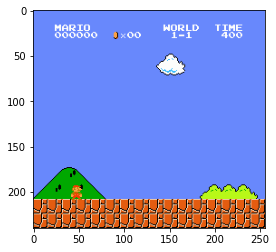

In [10]:
# Before Grayscaling
state = env.reset()
old = state.shape
print(old)
plt.imshow(state)

SuperMarioBros-v0
(240, 256, 1)
For each single frame we reduced information to process, from 184320 to 61440


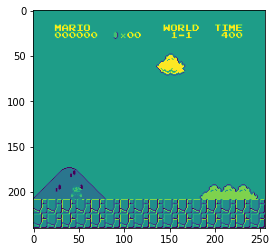

In [11]:
# Grayscaling
env = GrayScaleObservation(env, keep_dim=True) #we turn (240,256,3) into (240,256,1) --> without keep_dip=True we'd get (240,256) and we would not be able to work on frames!!
# After Grayscaling
id = env.unwrapped.spec.id
print(id)
state = env.reset()
new = state.shape
print(new)
plt.imshow(state)
print("For each single frame we reduced information to process, from",old[0]*old[1]*old[2], "to", new[0]*new[1]*new[2])

We now get our frame inside of 4 parallel vectorized environments (1, 240, 256, 1)


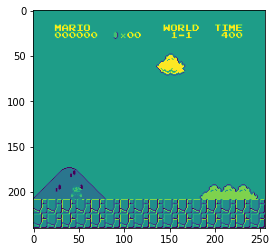

In [12]:
# Wrap inside the Vectorized Environment
env = DummyVecEnv([lambda: env])
state = env.reset()
print("We now get our frame inside of 4 parallel vectorized environments",state.shape)
plt.imshow(state[0])

In [13]:
# Stack the frames

env = VecFrameStack(env, 4, channels_order='last') #we stack 4 frames from our vectorized and grayscaled environment and we also specify that the channel order is the last element of the state --> (1, 240, 256, 1) it is the last one
state = env.reset()
print("We now have 4 different frames stacked, so what we get is: ",state.shape)

We now have 4 different frames stacked, so what we get is:  (1, 240, 256, 4)


In [14]:
# In order to have 4 frames, we need to perform 4 steps (remember, one step for each frame!). Let's tell Mario to do nothing 3 times (so we get starting frames + 3 frames)
state = env.reset()
env.step([0])
env.step([0])
state, reward, restart, info = env.step([0])

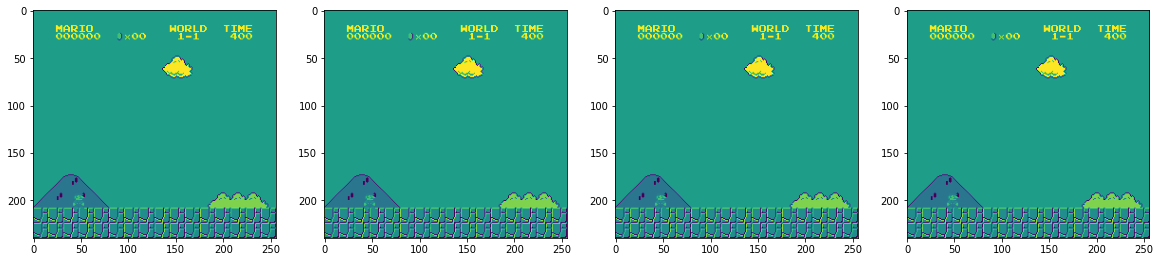

array([[[[  0,   0,   0, 140],
         [  0,   0,   0, 140],
         [  0,   0,   0, 140],
         ...,
         [  0,   0,   0, 140],
         [  0,   0,   0, 140],
         [  0,   0,   0, 140]],

        [[  0,   0,   0, 140],
         [  0,   0,   0, 140],
         [  0,   0,   0, 140],
         ...,
         [  0,   0,   0, 140],
         [  0,   0,   0, 140],
         [  0,   0,   0, 140]],

        [[  0,   0,   0, 140],
         [  0,   0,   0, 140],
         [  0,   0,   0, 140],
         ...,
         [  0,   0,   0, 140],
         [  0,   0,   0, 140],
         [  0,   0,   0, 140]],

        ...,

        [[  0,   0,   0, 214],
         [  0,   0,   0, 124],
         [  0,   0,   0, 124],
         ...,
         [  0,   0,   0, 124],
         [  0,   0,   0, 124],
         [  0,   0,   0,   0]],

        [[  0,   0,   0, 214],
         [  0,   0,   0, 124],
         [  0,   0,   0, 124],
         ...,
         [  0,   0,   0, 124],
         [  0,   0,   0,   0],
         

In [15]:
#let's plot using the last state (which will contain its frame but also the 3 previous stacked ones)
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()
#this way, we provided our AI with some sort of memory!

env.reset()

# 3. Train the RL Model

In [20]:
# This class is a standard Blueprint for training and also saving models, that can be used with any ML algorithm in stable_baselines3!

class TrainAndLoggingCallback(BaseCallback): #It is a child class of the generic BaseCallback parent class

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq #how frequently we want to save our model
        self.save_path = save_path #where do we want to save our model

    def _init_callback(self): #check if models directory exists and create it
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self): #each step check if we are multiple of the desired frequency --> if so, save model 
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [21]:
#Define directories to save models and logs
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [22]:
# Setup the callback with desired frequency and save_path
callback = TrainAndLoggingCallback(check_freq=100000, save_path=CHECKPOINT_DIR)

In [23]:
# Finally create the PPO AI Model!
#https://stable-baselines3.readthedocs.io/en/master/guide/custom_policy.html
#https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html
#CNNPolicy is the reccomendere feature extraction policy to feed the neural network with data extracted from images
#model = algorithm(policy, (gym) environment, verbose (if 1, we get lot of info during training), log directory, learning rate, number of steps (frames) for each neural network update)
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001 , n_steps=512) 

Using cuda device
Wrapping the env in a VecTransposeImage.


In [ ]:
# Train the AI model
model.learn(total_timesteps=1000000, callback=callback)

# 4. Test it Out

In [26]:
# Load model
model = PPO.load('./train/best_model_1000000')

In [27]:
state = env.reset()

In [ ]:
# Start the game 
state = env.reset()
# Loop through the game
while True: 
    
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()